<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7_9_%EA%B8%88_(popcorn_lstm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

평균 = 123.57604
최소 = 5
최대 = 1436
중앙값 = 92.0


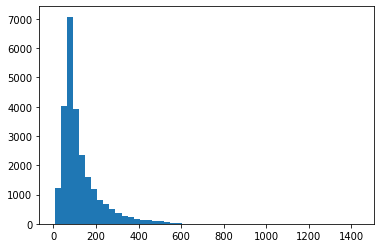

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 32)           1284512   
_________________________________________________________________
dropout (Dropout)            (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,309,409
Trainable params: 1,309,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - 6s 64ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/30
20/20 [

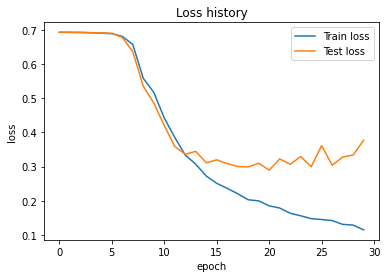


Accuracy = 88.26 %


In [10]:

# Word Embedding & LSTM을 이용한 감성분석
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pickle

# Commented out IPython magic to ensure Python compatibility.
# %cd '/content/drive/My Drive/Colab Notebooks'

# 학습, 시험 데이터를 읽어온다.
with open('/content/drive/MyDrive/머신러닝/popcorn.pkl', 'rb') as f:
    xd_train, yd_train, xd_test, yd_test = pickle.load(f)

xd_train[0]

# 학습, 시험 데이터를 합쳐서 사전 (vocabulary)을 구축한다.
x_data = xd_train + xd_test
y_target = np.array(yd_train + yd_test).reshape(-1,1)

# 사전을 구축하고 학습 데이터를 워드 인덱스로 표현한다.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_data)
x_idx = tokenizer.texts_to_sequences(x_data)

# vocabulary
word2idx = tokenizer.word_index
word2idx['<PAD>'] = 0

# 각 리뷰의 길이를 측정하고, 평균 길이를 구한다.
x_len = [len(x) for x in x_idx]

print('평균 =', np.mean(x_len))
print('최소 =', np.min(x_len))
print('최대 =', np.max(x_len))
print('중앙값 =', np.median(x_len))

# 길이 분포를 확인한다.
plt.hist(x_len, bins=50)
plt.show()

# 각 리뷰의 길이를 max_seq_len로 맞춘다. 길면 자르고, 짧으면 padding을 추가한다.
MAX_SEQ_LEN = 200
x_review = pad_sequences(x_idx, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
x_review[5000]

# 학습 데이터와 시험 데이터로 분리한다.
x_train, x_test, y_train, y_test = train_test_split(x_review, y_target, test_size=0.2)

# Embedding & LSTM 모델을 생성한다.
vocab_size = len(word2idx)
EMBEDDING_DIM = 32
HIDDEN_DIM = 64

x_input = Input(batch_shape=(None, x_train.shape[1]))
e_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM)(x_input)
e_layer = Dropout(rate=0.5)(e_layer)
r_layer = LSTM(HIDDEN_DIM, dropout=0.5)(e_layer)
y_output = Dense(1, activation='sigmoid')(r_layer)

model = Model(x_input, y_output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005))
model.summary()

# 학습
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 1024, epochs = 30)

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))
